### Load experiment meta-data

In [14]:
from sumo_python.helpers.load_experiment_metadata import load_experiment_config

In [2]:
input_path = "/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/"

In [3]:
config, sim_setup = load_experiment_config(config=input_path + 'config.json',
                        sim_setup=input_path + 'simulation_setups.json',)

In [15]:
config

{'NETWORK': PosixPath('/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data'),
 'SUMO': PosixPath('/usr/local/opt/sumo/share/sumo')}

# Run simulations

Steps:
1. Create OD meta-files that for a given count, creates a random trajectoy of vehicles moving from O -> D
2. Run SUMO against the latter files
3. Parse output of simulation and yields the aggregated value of vehicles which arrive to a given node in th network



### Step 1. Create OD meta-data

In [5]:
import numpy as np
from sumo_python.helpers.generate_od_xml import generate_od_xml


prefix_run = 'iter'
#od_rand = np.random.rand(4)*200
od_rand = np.array([500,500,900,900])
#print(prefix_run, np.sum(od_rand))
    
generate_od_xml(od_rand, config, sim_setup, prefix_run)


printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml


### Step 2-3: Run SUMO and parse output

In [6]:
from sumo_python.simulator.run_sumo_and_parse_output import run_sumo_and_parse_output

df_simulated = run_sumo_and_parse_output(config, sim_setup, prefix_run)


### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (10ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (3ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (5ms ~= 200.00*RT, ~131200.00UPS, vehicles TOT 2800 ACT 656 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simula

In [7]:
df_simulated

,EdgeID,interval_begin,interval_end,interval_nVehContrib,interval_harmonicMeanSpeed
0,#EdgeL5,54000.0,57600.0,959.0,13.500000
1,#EdgeL7,54000.0,57600.0,1243.0,13.603333


In [64]:
df_simulated

,EdgeID,interval_begin,interval_end,interval_nVehContrib,interval_harmonicMeanSpeed
0,#EdgeL5,54000.0,57600.0,319.666667,13.500000
1,#EdgeL7,54000.0,57600.0,414.333333,13.603333


### Obtain ground-truth

In [8]:
from sumo_python.simulator.ground_truth import run_ground_truth_and_parse
df_gt_data = run_ground_truth_and_parse(config, sim_setup)

od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.gt_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/gt_od_trips.trips.xml 
Success.
sumo --output-prefix gt_ --ignore-route-errors=true --net-file=/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml --routes=/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/gt_od_trips.trips.xml -b 54000 -e 57600 --additional-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml --duration-log.statistics --xml-validation never --vehroutes /Users/rodrse/Documents/DemandCalibration/notebooks

In [9]:
df_gt_data

,EdgeID,interval_begin,interval_end,interval_nVehContrib,interval_harmonicMeanSpeed
0,#EdgeL5,54000.0,57600.0,959,13.500000
1,#EdgeL7,54000.0,57600.0,1243,13.603333


# Compute objective

In [10]:
from sumo_python.helpers.nrmse_counts import compute_nrmse_counts

loss_estimate = compute_nrmse_counts(df_gt_data, df_simulated)
loss_estimate

0.0

### wrap objective x -> f(x)

In [16]:
def objective(x):
    
    prefix_run = 'iter'    
    generate_od_xml(x, config, sim_setup, prefix_run)
    df_simulated = run_sumo_and_parse_output(config, sim_setup, prefix_run)
    loss_estimate = compute_nrmse_counts(df_gt_data, df_simulated)
    df_output = pd.DataFrame(x.reshape(-1, len(x)),columns = ['x1','x2','x3','x4'])
    df_output['loss_estimate'] = loss_estimate
    
    return df_output

# Bayesian optimization

In [17]:
import os
import torch
import pandas as pd

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double


### Declare search space

In [18]:
# dimensionality of input space
d = 4 
bounds = torch.tensor([[400,400,400,400],[1000,1000,1000,1000]], device=device, dtype=dtype) 
bounds

tensor([[ 400.,  400.,  400.,  400.],
        [1000., 1000., 1000., 1000.]], dtype=torch.float64)

### Generate batch of policies using Sobol sequences

In [19]:
from torch.quasirandom import SobolEngine
n0 = 25
dim = 4
sobol = SobolEngine(dim, scramble=True)
x_0 = sobol.draw(n0).to(dtype=dtype)

In [20]:
from botorch.utils.transforms import unnormalize
# map the normalized into the original parameter space
train_X0 = unnormalize(x_0, bounds)


In [21]:
df_0 = [
    objective(x) for x in train_X0.cpu().detach().numpy()
]

df_0 = pd.concat(df_0)
df_0['iter'] = 0

printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (9ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (2ms).
Loading done.
Simulation version 1.16.0 started with time: 54000.00.
Step #57600.00 (7

Step #57600.00 (7ms ~= 142.86*RT, ~98142.86UPS, vehicles TOT 2691 ACT 687 BUF 0)          
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 16.37s
 Real time factor: 219.874
 UPS: 98077.078116
Vehicles: 
 Inserted: 2691
 Running: 687
 Waiting: 0
 Teleports: 2 (Wrong Lane: 2)
Statistics (avg of 2004):
 RouteLength: 4336.34
 Speed: 12.06
 Duration: 446.45
 WaitingTime: 84.64
 TimeLoss: 132.07
 DepartDelay: 0.50

DijkstraRouter answered 2691 queries and explored 10.06 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/note

Step #57600.00 (10ms ~= 100.00*RT, ~80600.00UPS, vehicles TOT 2865 ACT 806 BUF 344)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 22.94s
 Real time factor: 156.958
 UPS: 99120.029648
Vehicles: 
 Inserted: 2865 (Loaded: 3209)
 Running: 806
 Waiting: 344
 Teleports: 40 (Jam: 25, Wrong Lane: 15)
Statistics (avg of 2059):
 RouteLength: 4473.87
 Speed: 10.88
 Duration: 522.84
 WaitingTime: 101.47
 TimeLoss: 199.18
 DepartDelay: 0.49

DijkstraRouter answered 3294 queries and explored 10.61 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Doc

Step #57600.00 (6ms ~= 166.67*RT, ~142333.33UPS, vehicles TOT 2850 ACT 854 BUF 235)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 21.63s
 Real time factor: 166.436
 UPS: 108309.477577
Vehicles: 
 Inserted: 2850 (Loaded: 3085)
 Running: 854
 Waiting: 235
 Teleports: 18 (Jam: 10, Wrong Lane: 8)
Statistics (avg of 1996):
 RouteLength: 4440.39
 Speed: 10.39
 Duration: 567.53
 WaitingTime: 113.68
 TimeLoss: 245.70
 DepartDelay: 0.46

DijkstraRouter answered 3086 queries and explored 10.42 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Doc

Step #57600.00 (6ms ~= 166.67*RT, ~129333.33UPS, vehicles TOT 2514 ACT 776 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 17.97s
 Real time factor: 200.39
 UPS: 92265.237963
Vehicles: 
 Inserted: 2514
 Running: 776
 Waiting: 0
 Teleports: 2 (Jam: 1, Wrong Lane: 1)
Statistics (avg of 1738):
 RouteLength: 4360.00
 Speed: 12.38
 Duration: 446.25
 WaitingTime: 85.92
 TimeLoss: 130.41
 DepartDelay: 0.49

DijkstraRouter answered 2514 queries and explored 10.68 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibrati

Step #57600.00 (6ms ~= 166.67*RT, ~129833.33UPS, vehicles TOT 2771 ACT 779 BUF 58)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 17.37s
 Real time factor: 207.302
 UPS: 108367.557296
Vehicles: 
 Inserted: 2771 (Loaded: 2829)
 Running: 779
 Waiting: 58
 Teleports: 43 (Jam: 1, Wrong Lane: 42)
Statistics (avg of 1992):
 RouteLength: 4395.96
 Speed: 11.54
 Duration: 474.14
 WaitingTime: 95.82
 TimeLoss: 155.92
 DepartDelay: 0.52

DijkstraRouter answered 2936 queries and explored 10.32 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Docum

Step #57600.00 (10ms ~= 100.00*RT, ~86700.00UPS, vehicles TOT 2743 ACT 867 BUF 229)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 20.28s
 Real time factor: 177.48
 UPS: 102979.589824
Vehicles: 
 Inserted: 2743 (Loaded: 2972)
 Running: 867
 Waiting: 229
 Teleports: 20 (Jam: 11, Wrong Lane: 9)
Statistics (avg of 1876):
 RouteLength: 4394.04
 Speed: 12.48
 Duration: 432.79
 WaitingTime: 78.99
 TimeLoss: 114.07
 DepartDelay: 0.47

DijkstraRouter answered 2973 queries and explored 10.80 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Docum

Step #57600.00 (11ms ~= 90.91*RT, ~75000.00UPS, vehicles TOT 2981 ACT 825 BUF 503)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 28.35s
 Real time factor: 126.984
 UPS: 84290.229277
Vehicles: 
 Inserted: 2981 (Loaded: 3484)
 Running: 825
 Waiting: 503
 Teleports: 25 (Jam: 13, Wrong Lane: 12)
Statistics (avg of 2156):
 RouteLength: 4384.52
 Speed: 11.10
 Duration: 505.92
 WaitingTime: 103.90
 TimeLoss: 187.96
 DepartDelay: 1.07

DijkstraRouter answered 3671 queries and explored 10.19 edges on average.
DijkstraRouter spent 0.02s answering queries (0.00ms on average).
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Doc

Step #57600.00 (13ms ~= 76.92*RT, ~63846.15UPS, vehicles TOT 3081 ACT 830 BUF 36)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 22.29s
 Real time factor: 161.5
 UPS: 97166.120856
Vehicles: 
 Inserted: 3081 (Loaded: 3117)
 Running: 830
 Waiting: 36
 Teleports: 7 (Wrong Lane: 7)
Statistics (avg of 2251):
 RouteLength: 4350.87
 Speed: 10.74
 Duration: 538.23
 WaitingTime: 105.67
 TimeLoss: 222.79
 DepartDelay: 0.49

DijkstraRouter answered 3127 queries and explored 9.92 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCa

Step #57600.00 (11ms ~= 90.91*RT, ~98363.64UPS, vehicles TOT 3316 ACT 1082 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 25.91s
 Real time factor: 138.948
 UPS: 94918.715504
Vehicles: 
 Inserted: 3316
 Running: 1082
 Waiting: 0
 Teleports: 1 (Yield: 1)
Statistics (avg of 2234):
 RouteLength: 4253.04
 Speed: 10.84
 Duration: 600.19
 WaitingTime: 141.70
 TimeLoss: 292.01
 DepartDelay: 0.48

DijkstraRouter answered 3316 queries and explored 9.74 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebook

Step #57600.00 (10ms ~= 100.00*RT, ~76200.00UPS, vehicles TOT 2336 ACT 762 BUF 240)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 24.56s
 Real time factor: 146.592
 UPS: 79857.276651
Vehicles: 
 Inserted: 2336 (Loaded: 2576)
 Running: 762
 Waiting: 240
 Teleports: 47 (Jam: 8, Wrong Lane: 39)
Statistics (avg of 1574):
 RouteLength: 4475.48
 Speed: 11.85
 Duration: 503.73
 WaitingTime: 126.61
 TimeLoss: 179.21
 DepartDelay: 0.49

DijkstraRouter answered 2576 queries and explored 11.11 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Docu

Step #57600.00 (11ms ~= 90.91*RT, ~73727.27UPS, vehicles TOT 2780 ACT 811 BUF 286)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 23.95s
 Real time factor: 150.307
 UPS: 84728.696088
Vehicles: 
 Inserted: 2780 (Loaded: 3066)
 Running: 811
 Waiting: 286
 Teleports: 10 (Jam: 3, Wrong Lane: 7)
Statistics (avg of 1969):
 RouteLength: 4335.38
 Speed: 11.66
 Duration: 462.07
 WaitingTime: 93.62
 TimeLoss: 147.97
 DepartDelay: 0.61

DijkstraRouter answered 3225 queries and explored 10.08 edges on average.
DijkstraRouter spent 0.02s answering queries (0.00ms on average).
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Docume

Step #57600.00 (8ms ~= 125.00*RT, ~110375.00UPS, vehicles TOT 3091 ACT 883 BUF 179)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 28.20s
 Real time factor: 127.646
 UPS: 79462.716732
Vehicles: 
 Inserted: 3091 (Loaded: 3270)
 Running: 883
 Waiting: 179
 Teleports: 19 (Jam: 11, Wrong Lane: 8)
Statistics (avg of 2208):
 RouteLength: 4384.39
 Speed: 11.40
 Duration: 480.25
 WaitingTime: 90.64
 TimeLoss: 162.48
 DepartDelay: 0.49

DijkstraRouter answered 3332 queries and explored 10.26 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Docum

Step #57600.00 (13ms ~= 76.92*RT, ~82153.85UPS, vehicles TOT 3137 ACT 1068 BUF 62)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 33.81s
 Real time factor: 106.481
 UPS: 78682.776775
Vehicles: 
 Inserted: 3137 (Loaded: 3199)
 Running: 1068
 Waiting: 62
 Teleports: 15 (Jam: 8, Wrong Lane: 7)
Statistics (avg of 2069):
 RouteLength: 4374.23
 Speed: 9.74
 Duration: 720.05
 WaitingTime: 179.54
 TimeLoss: 403.38
 DepartDelay: 0.50

DijkstraRouter answered 3212 queries and explored 10.33 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).


### GP model surrogate

In [22]:
import torch
import matplotlib.pyplot as plt

from botorch.models.transforms import Normalize, Standardize

from botorch.utils.transforms import normalize

from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_mll


train_X = torch.from_numpy(df_0[["x1","x2","x3","x4"]].values)
train_X_norm = normalize(train_X,bounds)

train_Y = -torch.from_numpy(df_0[["loss_estimate"]].values)


def initialize_gp_model(train_X,train_Y):
            
    gp_model = SingleTaskGP(
        train_X=train_X,
        train_Y=train_Y,
        outcome_transform=Standardize(m=1)
    )

    gp_mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    
    return gp_model, gp_mll


gp_model, gp_mll = initialize_gp_model(train_X_norm,train_Y)

# Fit model
fit_gpytorch_mll(gp_mll)


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
    (outcome_transform): Standardize()
  )
)

### Acquisition Function: q-EI

In [23]:
# Acquisition function
from botorch.acquisition import qExpectedImprovement
from botorch.sampling.stochastic_samplers import StochasticSampler

sampler = StochasticSampler(sample_shape=torch.Size([128]))
qEI = qExpectedImprovement(gp_model, best_f=max(train_Y), sampler=sampler)


In [24]:
from botorch.utils.transforms import unnormalize
from botorch.optim import optimize_acqf
    
def optimize_acqf_and_get_observation(acq_func,bounds):
    """Optimizes the acquisition function, and returns a new candidate."""
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=torch.tensor([[0.0] * dim, [1.0] * dim], device=device, dtype=dtype),
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )

    # observe new values 
    new_x = candidates.detach()
    
    return unnormalize(new_x, bounds)

In [25]:
BATCH_SIZE = 1 
NUM_RESTARTS = 5 
RAW_SAMPLES = 32 

new_x = optimize_acqf_and_get_observation(
    acq_func=qEI,
    bounds=bounds
)

new_x


tensor([[ 735.3012,  655.5877, 1000.0000,  998.2975]], dtype=torch.float64)

### Run loop

In [31]:
NITER = 175
output = [df_0]
best_value = []

for i in range(NITER):
    
    print(f"####### {i+1} ########")
    
    df_ = df_0 if i == 0 else df_i
    
    n_obs = df_.shape[0]
    print(f"##### n={n_obs} #####")
    
    # Training data
    train_X = torch.from_numpy(df_[["x1","x2","x3","x4"]].values)    
    train_X_norm = normalize(train_X,bounds)
    
    train_Y = -torch.from_numpy(df_[["loss_estimate"]].values) # Take negative
    
    # best value so far
    best_y = train_Y.max()
    best_value.append(best_y)
    print(f"##### best_value={best_y} #####")

    # Declare model with newest data
    gp_model, gp_mll = initialize_gp_model(train_X_norm,train_Y)

    # Fit model
    fit_gpytorch_mll(gp_mll)

    # Construct acquistion function 
    sampler = StochasticSampler(sample_shape=torch.Size([128]))
    qEI = qExpectedImprovement(gp_model, best_f=best_y, sampler=sampler)
    
    # Maximize acquisition function to get next observation
    new_x = optimize_acqf_and_get_observation(acq_func=qEI,bounds=bounds)
    
    # Query SUMO on new sampling location
    df_simulation = objective(new_x.cpu().detach().numpy().reshape(-1))
    df_simulation['iter'] = i+1
    
    # Update history of training data
    output.append(df_simulation)
    
    df_i = pd.concat(output)
    
    
    

####### 1 ########
##### n=25 #####
##### best_value=-0.03369774107009836 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (8ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (2ms).
Loadin

Step #57600.00 (13ms ~= 76.92*RT, ~76076.92UPS, vehicles TOT 3244 ACT 989 BUF 0)          
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 27.04s
 Real time factor: 133.126
 UPS: 84375.120183
Vehicles: 
 Inserted: 3244
 Running: 989
 Waiting: 0
 Teleports: 4 (Yield: 1, Wrong Lane: 3)
Statistics (avg of 2255):
 RouteLength: 4247.54
 Speed: 10.96
 Duration: 566.76
 WaitingTime: 127.59
 TimeLoss: 258.85
 DepartDelay: 0.50

DijkstraRouter answered 3244 queries and explored 9.61 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 2 ########
##### n=26 #####
##### best_value=-0.03369774107009836 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/

Step #57600.00 (7ms ~= 142.86*RT, ~119285.71UPS, vehicles TOT 2967 ACT 835 BUF 343)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 20.38s
 Real time factor: 176.644
 UPS: 106062.757605
Vehicles: 
 Inserted: 2967 (Loaded: 3310)
 Running: 835
 Waiting: 343
 Teleports: 18 (Jam: 12, Wrong Lane: 6)
Statistics (avg of 2132):
 RouteLength: 4338.78
 Speed: 12.09
 Duration: 440.46
 WaitingTime: 82.70
 TimeLoss: 126.07
 DepartDelay: 0.57

DijkstraRouter answered 3462 queries and explored 10.27 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 5 ########
##### n=29 #####
##### best_value=-0.03369774107009836 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo

Step #57600.00 (7ms ~= 142.86*RT, ~109000.00UPS, vehicles TOT 3185 ACT 763 BUF 391)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 26.98s
 Real time factor: 133.437
 UPS: 90201.712443
Vehicles: 
 Inserted: 3185 (Loaded: 3576)
 Running: 763
 Waiting: 391
 Teleports: 11 (Jam: 3, Wrong Lane: 8)
Statistics (avg of 2422):
 RouteLength: 4394.17
 Speed: 10.61
 Duration: 542.02
 WaitingTime: 91.62
 TimeLoss: 222.65
 DepartDelay: 1.07

DijkstraRouter answered 3673 queries and explored 10.14 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 8 ########
##### n=32 #####
##### best_value=-0.029751751778672477 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_

Step #57600.00 (6ms ~= 166.67*RT, ~131166.67UPS, vehicles TOT 2978 ACT 787 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 15.58s
 Real time factor: 231.14
 UPS: 122839.935795
Vehicles: 
 Inserted: 2978
 Running: 787
 Waiting: 0
 Teleports: 1 (Wrong Lane: 1)
Statistics (avg of 2191):
 RouteLength: 4413.56
 Speed: 11.37
 Duration: 471.12
 WaitingTime: 78.11
 TimeLoss: 150.86
 DepartDelay: 0.50

DijkstraRouter answered 2978 queries and explored 10.27 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 9 ########
##### n=33 #####
##### best_value=-0.029751751778672477 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quic

Step #57600.00 (9ms ~= 111.11*RT, ~88888.89UPS, vehicles TOT 2871 ACT 800 BUF 311)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 21.68s
 Real time factor: 166.029
 UPS: 94024.120279
Vehicles: 
 Inserted: 2871 (Loaded: 3182)
 Running: 800
 Waiting: 311
 Teleports: 6 (Jam: 2, Wrong Lane: 4)
Statistics (avg of 2071):
 RouteLength: 4376.61
 Speed: 11.83
 Duration: 453.67
 WaitingTime: 86.39
 TimeLoss: 136.44
 DepartDelay: 2.57

DijkstraRouter answered 3360 queries and explored 10.36 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 18 ########
##### n=42 #####
##### best_value=-0.009014274859799823 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_

DijkstraRouter answered 2665 queries and explored 9.90 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 20 ########
##### n=44 #####
##### best_value=-0.009014274859799823 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (6ms).
Loading additional-files from '/U

Step #57600.00 (9ms ~= 111.11*RT, ~91000.00UPS, vehicles TOT 2822 ACT 819 BUF 289)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 19.60s
 Real time factor: 183.664
 UPS: 102537.013418
Vehicles: 
 Inserted: 2822 (Loaded: 3111)
 Running: 819
 Waiting: 289
 Teleports: 14 (Jam: 7, Wrong Lane: 7)
Statistics (avg of 2003):
 RouteLength: 4262.87
 Speed: 12.25
 Duration: 429.77
 WaitingTime: 79.48
 TimeLoss: 120.36
 DepartDelay: 0.49

DijkstraRouter answered 3210 queries and explored 10.05 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 22 ########
##### n=46 #####
##### best_value=-0.009014274859799823 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sum

Step #57600.00 (10ms ~= 100.00*RT, ~79500.00UPS, vehicles TOT 2742 ACT 795 BUF 116)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 20.04s
 Real time factor: 179.623
 UPS: 101826.514320
Vehicles: 
 Inserted: 2742 (Loaded: 2858)
 Running: 795
 Waiting: 116
 Teleports: 19 (Jam: 7, Wrong Lane: 12)
Statistics (avg of 1947):
 RouteLength: 4440.33
 Speed: 10.96
 Duration: 512.44
 WaitingTime: 100.99
 TimeLoss: 190.31
 DepartDelay: 0.49

DijkstraRouter answered 2907 queries and explored 10.43 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 24 ########
##### n=48 #####
##### best_value=-0.009014274859799823 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_s

Step #57600.00 (38ms ~= 26.32*RT, ~19052.63UPS, vehicles TOT 2753 ACT 724 BUF 0)          
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 1818.03s
 Real time factor: 1.98017
 UPS: 953.090983
Vehicles: 
 Inserted: 2753
 Running: 724
 Waiting: 0
 Teleports: 2 (Jam: 2)
Statistics (avg of 2029):
 RouteLength: 4323.70
 Speed: 11.43
 Duration: 481.92
 WaitingTime: 101.91
 TimeLoss: 168.28
 DepartDelay: 0.49

DijkstraRouter answered 2753 queries and explored 9.87 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 29 ########
##### n=53 #####
##### best_value=-0.009014274859799823 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart

Step #57600.00 (45ms ~= 22.22*RT, ~24400.00UPS, vehicles TOT 3175 ACT 1098 BUF 168)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 105.89s
 Real time factor: 33.9992
 UPS: 24164.773103
Vehicles: 
 Inserted: 3175 (Loaded: 3343)
 Running: 1098
 Waiting: 168
 Teleports: 4 (Wrong Lane: 4)
Statistics (avg of 2077):
 RouteLength: 4276.05
 Speed: 10.51
 Duration: 651.39
 WaitingTime: 176.59
 TimeLoss: 341.58
 DepartDelay: 5.69

DijkstraRouter answered 3646 queries and explored 9.97 edges on average.
DijkstraRouter spent 0.05s answering queries (0.01ms on average).
####### 30 ########
##### n=54 #####
##### best_value=-0.009014274859799823 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/

Step #57600.00 (15ms ~= 66.67*RT, ~61533.33UPS, vehicles TOT 2970 ACT 923 BUF 28)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 40.80s
 Real time factor: 88.2461
 UPS: 55211.153328
Vehicles: 
 Inserted: 2970 (Loaded: 2998)
 Running: 923
 Waiting: 28
 Teleports: 16 (Jam: 1, Yield: 1, Wrong Lane: 14)
Statistics (avg of 2047):
 RouteLength: 4360.46
 Speed: 10.27
 Duration: 605.17
 WaitingTime: 121.21
 TimeLoss: 289.38
 DepartDelay: 0.49

DijkstraRouter answered 3088 queries and explored 10.11 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 33 ########
##### n=57 #####
##### best_value=-0.009014274859799823 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calib

Step #57600.00 (8ms ~= 125.00*RT, ~95000.00UPS, vehicles TOT 2997 ACT 760 BUF 0)          
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 111.32s
 Real time factor: 32.3386
 UPS: 16654.695388
Vehicles: 
 Inserted: 2997
 Running: 760
 Waiting: 0
 Teleports: 1 (Wrong Lane: 1)
Statistics (avg of 2237):
 RouteLength: 4367.81
 Speed: 11.64
 Duration: 454.55
 WaitingTime: 80.73
 TimeLoss: 137.77
 DepartDelay: 0.47

DijkstraRouter answered 2997 queries and explored 10.06 edges on average.
DijkstraRouter spent 0.04s answering queries (0.01ms on average).
####### 36 ########
##### n=60 #####
##### best_value=-0.009014274859799823 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/qu

Step #57600.00 (13ms ~= 76.92*RT, ~82076.92UPS, vehicles TOT 3457 ACT 1067 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 30.00s
 Real time factor: 119.984
 UPS: 82115.017998
Vehicles: 
 Inserted: 3457
 Running: 1067
 Waiting: 0
 Teleports: 7 (Wrong Lane: 7)
Statistics (avg of 2390):
 RouteLength: 4240.34
 Speed: 11.01
 Duration: 569.58
 WaitingTime: 132.90
 TimeLoss: 262.51
 DepartDelay: 0.48

DijkstraRouter answered 3457 queries and explored 9.60 edges on average.
DijkstraRouter spent 0.02s answering queries (0.00ms on average).
####### 45 ########
##### n=69 #####
##### best_value=-0.009014274859799823 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/qu

Step #57600.00 (9ms ~= 111.11*RT, ~91444.44UPS, vehicles TOT 2727 ACT 823 BUF 212)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 25.37s
 Real time factor: 141.911
 UPS: 87650.465153
Vehicles: 
 Inserted: 2727 (Loaded: 2939)
 Running: 823
 Waiting: 212
 Teleports: 42 (Jam: 7, Wrong Lane: 35)
Statistics (avg of 1904):
 RouteLength: 4486.33
 Speed: 10.38
 Duration: 551.83
 WaitingTime: 127.23
 TimeLoss: 227.06
 DepartDelay: 0.49

DijkstraRouter answered 2940 queries and explored 10.74 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 46 ########
##### n=70 #####
##### best_value=-0.009014274859799823 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_su

Step #57600.00 (8ms ~= 125.00*RT, ~108000.00UPS, vehicles TOT 2801 ACT 864 BUF 39)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 22.95s
 Real time factor: 156.897
 UPS: 81564.959686
Vehicles: 
 Inserted: 2801 (Loaded: 2840)
 Running: 864
 Waiting: 39
 Teleports: 7 (Jam: 5, Wrong Lane: 2)
Statistics (avg of 1937):
 RouteLength: 4363.50
 Speed: 12.29
 Duration: 440.24
 WaitingTime: 82.49
 TimeLoss: 123.78
 DepartDelay: 0.50

DijkstraRouter answered 2847 queries and explored 10.43 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 48 ########
##### n=72 #####
##### best_value=-0.009014274859799823 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_f

Step #57600.00 (10ms ~= 100.00*RT, ~87600.00UPS, vehicles TOT 3021 ACT 876 BUF 183)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 22.57s
 Real time factor: 159.483
 UPS: 94345.412661
Vehicles: 
 Inserted: 3021 (Loaded: 3204)
 Running: 876
 Waiting: 183
 Teleports: 13 (Jam: 7, Wrong Lane: 6)
Statistics (avg of 2145):
 RouteLength: 4390.73
 Speed: 11.75
 Duration: 455.03
 WaitingTime: 80.02
 TimeLoss: 136.68
 DepartDelay: 0.48

DijkstraRouter answered 3306 queries and explored 10.34 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 49 ########
##### n=73 #####
##### best_value=-0.009014274859799823 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo

Step #57400.00

Step #57600.00 (9ms ~= 111.11*RT, ~97222.22UPS, vehicles TOT 3357 ACT 875 BUF 223)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 31.08s
 Real time factor: 115.815
 UPS: 79939.518723
Vehicles: 
 Inserted: 3357 (Loaded: 3580)
 Running: 875
 Waiting: 223
 Teleports: 7 (Jam: 4, Wrong Lane: 3)
Statistics (avg of 2482):
 RouteLength: 4371.75
 Speed: 10.60
 Duration: 550.87
 WaitingTime: 96.38
 TimeLoss: 233.49
 DepartDelay: 0.50

DijkstraRouter answered 3731 queries and explored 10.01 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 51 ########
##### n=75 #####
##### best_value=-0.009014274859799823 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_

Step #57600.00 (10ms ~= 100.00*RT, ~87900.00UPS, vehicles TOT 2952 ACT 879 BUF 230)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 25.75s
 Real time factor: 139.784
 UPS: 82118.001087
Vehicles: 
 Inserted: 2952 (Loaded: 3182)
 Running: 879
 Waiting: 230
 Teleports: 20 (Jam: 11, Wrong Lane: 9)
Statistics (avg of 2073):
 RouteLength: 4361.50
 Speed: 12.42
 Duration: 422.45
 WaitingTime: 71.74
 TimeLoss: 105.92
 DepartDelay: 0.50

DijkstraRouter answered 3287 queries and explored 10.46 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).


####### 52 ########
##### n=76 #####
##### best_value=-0.009014274859799823 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (6ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (2ms).
Load

Step #57600.00 (10ms ~= 100.00*RT, ~90000.00UPS, vehicles TOT 3135 ACT 900 BUF 65)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 25.37s
 Real time factor: 141.911
 UPS: 84120.584989
Vehicles: 
 Inserted: 3135 (Loaded: 3200)
 Running: 900
 Waiting: 65
 Teleports: 2 (Jam: 1, Wrong Lane: 1)
Statistics (avg of 2235):
 RouteLength: 4252.18
 Speed: 10.97
 Duration: 554.09
 WaitingTime: 140.41
 TimeLoss: 246.30
 DepartDelay: 0.46

DijkstraRouter answered 3201 queries and explored 9.46 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 53 ########
##### n=77 #####
##### best_value=-0.009014274859799823 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_f

Step #57600.00 (7ms ~= 142.86*RT, ~92142.86UPS, vehicles TOT 2779 ACT 645 BUF 0)          
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 14.48s
 Real time factor: 248.653
 UPS: 111020.237602
Vehicles: 
 Inserted: 2779
 Running: 645
 Waiting: 0
 Teleports: 6 (Jam: 6)
Statistics (avg of 2134):
 RouteLength: 4243.69
 Speed: 11.78
 Duration: 453.80
 WaitingTime: 92.29
 TimeLoss: 146.41
 DepartDelay: 0.49

DijkstraRouter answered 2779 queries and explored 9.34 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 56 ########
##### n=80 #####
##### best_value=-0.009014274859799823 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart

Step #57600.00 (9ms ~= 111.11*RT, ~97555.56UPS, vehicles TOT 3033 ACT 878 BUF 325)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 22.93s
 Real time factor: 157.02
 UPS: 101520.434422
Vehicles: 
 Inserted: 3033 (Loaded: 3358)
 Running: 878
 Waiting: 325
 Teleports: 27 (Jam: 13, Wrong Lane: 14)
Statistics (avg of 2155):
 RouteLength: 4444.48
 Speed: 11.53
 Duration: 473.81
 WaitingTime: 87.07
 TimeLoss: 151.28
 DepartDelay: 0.65

DijkstraRouter answered 3562 queries and explored 10.62 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 61 ########
##### n=85 #####
##### best_value=-0.0037448734110968763 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_s

Step #57600.00 (8ms ~= 125.00*RT, ~110000.00UPS, vehicles TOT 2914 ACT 880 BUF 211)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 21.27s
 Real time factor: 169.276
 UPS: 103754.549302
Vehicles: 
 Inserted: 2914 (Loaded: 3125)
 Running: 880
 Waiting: 211
 Teleports: 13 (Jam: 7, Wrong Lane: 6)
Statistics (avg of 2034):
 RouteLength: 4469.68
 Speed: 11.66
 Duration: 470.73
 WaitingTime: 88.55
 TimeLoss: 147.47
 DepartDelay: 0.50

DijkstraRouter answered 3125 queries and explored 10.70 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 62 ########
##### n=86 #####
##### best_value=-0.0037448734110968763 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_su

Step #57600.00 (10ms ~= 100.00*RT, ~89300.00UPS, vehicles TOT 3088 ACT 893 BUF 363)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 23.74s
 Real time factor: 151.668
 UPS: 100551.693630
Vehicles: 
 Inserted: 3088 (Loaded: 3451)
 Running: 893
 Waiting: 363
 Teleports: 27 (Jam: 16, Wrong Lane: 11)
Statistics (avg of 2195):
 RouteLength: 4455.72
 Speed: 11.85
 Duration: 447.65
 WaitingTime: 73.59
 TimeLoss: 123.85
 DepartDelay: 0.45

DijkstraRouter answered 3452 queries and explored 10.68 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 63 ########
##### n=87 #####
##### best_value=-0.0037448734110968763 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_

Step #57600.00 (9ms ~= 111.11*RT, ~94666.67UPS, vehicles TOT 2920 ACT 852 BUF 425)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 22.29s
 Real time factor: 161.507
 UPS: 102926.873037
Vehicles: 
 Inserted: 2920 (Loaded: 3345)
 Running: 852
 Waiting: 425
 Teleports: 23 (Jam: 15, Wrong Lane: 8)
Statistics (avg of 2068):
 RouteLength: 4391.51
 Speed: 11.73
 Duration: 459.68
 WaitingTime: 87.37
 TimeLoss: 141.01
 DepartDelay: 0.51

DijkstraRouter answered 3437 queries and explored 10.38 edges on average.
DijkstraRouter spent 0.02s answering queries (0.00ms on average).
####### 64 ########
##### n=88 #####
##### best_value=-0.0037448734110968763 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_s

Step #57600.00 (10ms ~= 100.00*RT, ~92100.00UPS, vehicles TOT 3046 ACT 921 BUF 175)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 21.65s
 Real time factor: 166.32
 UPS: 100836.682837
Vehicles: 
 Inserted: 3046 (Loaded: 3221)
 Running: 921
 Waiting: 175
 Teleports: 18 (Jam: 9, Wrong Lane: 9)
Statistics (avg of 2125):
 RouteLength: 4440.63
 Speed: 12.45
 Duration: 421.21
 WaitingTime: 65.88
 TimeLoss: 99.02
 DepartDelay: 0.50

DijkstraRouter answered 3222 queries and explored 10.84 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 65 ########
##### n=89 #####
##### best_value=-0.0037448734110968763 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo

Step #57600.00 (12ms ~= 83.33*RT, ~68666.67UPS, vehicles TOT 3020 ACT 824 BUF 357)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 26.58s
 Real time factor: 135.445
 UPS: 82395.086346
Vehicles: 
 Inserted: 3020 (Loaded: 3377)
 Running: 824
 Waiting: 357
 Teleports: 12 (Jam: 7, Wrong Lane: 5)
Statistics (avg of 2196):
 RouteLength: 4284.10
 Speed: 11.54
 Duration: 475.26
 WaitingTime: 102.66
 TimeLoss: 164.94
 DepartDelay: 1.21

DijkstraRouter answered 3587 queries and explored 9.81 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 68 ########
##### n=92 #####
##### best_value=-0.0037448734110968763 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sum

Step #57600.00 (11ms ~= 90.91*RT, ~78818.18UPS, vehicles TOT 3139 ACT 867 BUF 41)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 27.03s
 Real time factor: 133.166
 UPS: 82262.817193
Vehicles: 
 Inserted: 3139 (Loaded: 3180)
 Running: 867
 Waiting: 41
 Teleports: 2 (Yield: 2)
Statistics (avg of 2272):
 RouteLength: 4322.43
 Speed: 10.59
 Duration: 568.79
 WaitingTime: 95.44
 TimeLoss: 254.97
 DepartDelay: 0.49

DijkstraRouter answered 3180 queries and explored 9.84 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 70 ########
##### n=94 #####
##### best_value=-0.0037448734110968763 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quicksta

Step #57600.00 (11ms ~= 90.91*RT, ~85272.73UPS, vehicles TOT 3118 ACT 938 BUF 0)          
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 27.49s
 Real time factor: 130.976
 UPS: 82248.490140
Vehicles: 
 Inserted: 3118
 Running: 938
 Waiting: 0
 Teleports: 2 (Yield: 2)
Statistics (avg of 2180):
 RouteLength: 4330.22
 Speed: 10.44
 Duration: 594.14
 WaitingTime: 124.59
 TimeLoss: 280.19
 DepartDelay: 0.49

DijkstraRouter answered 3118 queries and explored 9.97 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 72 ########
##### n=96 #####
##### best_value=-0.0037448734110968763 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickst

Step #57600.00 (8ms ~= 125.00*RT, ~107500.00UPS, vehicles TOT 2382 ACT 860 BUF 16)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 20.80s
 Real time factor: 173.069
 UPS: 85459.881736
Vehicles: 
 Inserted: 2382 (Loaded: 2398)
 Running: 860
 Waiting: 16
 Teleports: 14 (Jam: 2, Wrong Lane: 12)
Statistics (avg of 1522):
 RouteLength: 4415.42
 Speed: 12.17
 Duration: 474.69
 WaitingTime: 103.50
 TimeLoss: 154.35
 DepartDelay: 0.49

DijkstraRouter answered 2398 queries and explored 10.88 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 73 ########
##### n=97 #####
##### best_value=-0.0037448734110968763 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_su

Step #57600.00 (10ms ~= 100.00*RT, ~90400.00UPS, vehicles TOT 3012 ACT 904 BUF 217)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 26.60s
 Real time factor: 135.349
 UPS: 83300.398526
Vehicles: 
 Inserted: 3012 (Loaded: 3229)
 Running: 904
 Waiting: 217
 Teleports: 14 (Jam: 7, Wrong Lane: 7)
Statistics (avg of 2108):
 RouteLength: 4457.80
 Speed: 12.11
 Duration: 435.14
 WaitingTime: 71.06
 TimeLoss: 111.39
 DepartDelay: 0.50

DijkstraRouter answered 3230 queries and explored 10.71 edges on average.
DijkstraRouter spent 0.03s answering queries (0.01ms on average).
####### 74 ########
##### n=98 #####
##### best_value=-0.0037448734110968763 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sum

Step #57600.00 (8ms ~= 125.00*RT, ~101750.00UPS, vehicles TOT 3003 ACT 814 BUF 236)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 28.78s
 Real time factor: 125.096
 UPS: 83711.376746
Vehicles: 
 Inserted: 3003 (Loaded: 3239)
 Running: 814
 Waiting: 236
 Teleports: 49 (Jam: 5, Wrong Lane: 44)
Statistics (avg of 2189):
 RouteLength: 4435.02
 Speed: 10.05
 Duration: 601.42
 WaitingTime: 115.90
 TimeLoss: 280.21
 DepartDelay: 0.50

DijkstraRouter answered 3354 queries and explored 10.28 edges on average.
DijkstraRouter spent 0.03s answering queries (0.01ms on average).
####### 75 ########
##### n=99 #####
##### best_value=-0.0037448734110968763 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_s

Step #57600.00 (8ms ~= 125.00*RT, ~113250.00UPS, vehicles TOT 3021 ACT 906 BUF 188)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 20.68s
 Real time factor: 174.115
 UPS: 104145.482685
Vehicles: 
 Inserted: 3021 (Loaded: 3209)
 Running: 906
 Waiting: 188
 Teleports: 19 (Jam: 10, Wrong Lane: 9)
Statistics (avg of 2115):
 RouteLength: 4445.96
 Speed: 12.37
 Duration: 426.03
 WaitingTime: 68.82
 TimeLoss: 103.66
 DepartDelay: 0.50

DijkstraRouter answered 3210 queries and explored 10.74 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 78 ########
##### n=102 #####
##### best_value=-0.0037448734110968763 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_

Step #57600.00 (9ms ~= 111.11*RT, ~101111.11UPS, vehicles TOT 3186 ACT 910 BUF 238)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 18.32s
 Real time factor: 196.496
 UPS: 124033.076797
Vehicles: 
 Inserted: 3186 (Loaded: 3424)
 Running: 910
 Waiting: 238
 Teleports: 16 (Jam: 9, Wrong Lane: 7)
Statistics (avg of 2276):
 RouteLength: 4427.66
 Speed: 12.29
 Duration: 422.54
 WaitingTime: 65.63
 TimeLoss: 101.39
 DepartDelay: 0.48

DijkstraRouter answered 3425 queries and explored 10.65 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 81 ########
##### n=105 #####
##### best_value=-0.0037448734110968763 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_s

Step #57600.00 (10ms ~= 100.00*RT, ~87800.00UPS, vehicles TOT 3011 ACT 878 BUF 44)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 16.52s
 Real time factor: 217.891
 UPS: 123888.149134
Vehicles: 
 Inserted: 3011 (Loaded: 3055)
 Running: 878
 Waiting: 44
 Teleports: 7 (Jam: 2, Wrong Lane: 5)
Statistics (avg of 2133):
 RouteLength: 4331.11
 Speed: 11.37
 Duration: 477.33
 WaitingTime: 89.80
 TimeLoss: 163.51
 DepartDelay: 0.49

DijkstraRouter answered 3055 queries and explored 9.91 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 83 ########
##### n=107 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_

Step #57600.00 (9ms ~= 111.11*RT, ~98333.33UPS, vehicles TOT 2748 ACT 885 BUF 0)          
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 17.59s
 Real time factor: 204.627
 UPS: 119874.268175
Vehicles: 
 Inserted: 2748
 Running: 885
 Waiting: 0
 Teleports: 35 (Jam: 15, Wrong Lane: 20)
Statistics (avg of 1863):
 RouteLength: 4418.57
 Speed: 9.89
 Duration: 637.91
 WaitingTime: 138.40
 TimeLoss: 317.56
 DepartDelay: 0.49

DijkstraRouter answered 2748 queries and explored 10.43 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 84 ########
##### n=108 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quicks

Step #57600.00 (9ms ~= 111.11*RT, ~100000.00UPS, vehicles TOT 3034 ACT 900 BUF 289)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 19.02s
 Real time factor: 189.274
 UPS: 119946.109359
Vehicles: 
 Inserted: 3034 (Loaded: 3323)
 Running: 900
 Waiting: 289
 Teleports: 23 (Jam: 12, Wrong Lane: 11)
Statistics (avg of 2134):
 RouteLength: 4421.11
 Speed: 12.06
 Duration: 434.66
 WaitingTime: 71.65
 TimeLoss: 114.42
 DepartDelay: 0.49

DijkstraRouter answered 3323 queries and explored 10.58 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 87 ########
##### n=111 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_

Step #57600.00 (8ms ~= 125.00*RT, ~106750.00UPS, vehicles TOT 2537 ACT 854 BUF 119)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 14.62s
 Real time factor: 246.188
 UPS: 130014.976407
Vehicles: 
 Inserted: 2537 (Loaded: 2656)
 Running: 854
 Waiting: 119
 Teleports: 17 (Jam: 9, Wrong Lane: 8)
Statistics (avg of 1683):
 RouteLength: 4447.81
 Speed: 12.33
 Duration: 443.18
 WaitingTime: 80.71
 TimeLoss: 120.25
 DepartDelay: 0.49

DijkstraRouter answered 2662 queries and explored 10.88 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 89 ########
##### n=113 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_su

Step #57600.00 (10ms ~= 100.00*RT, ~103100.00UPS, vehicles TOT 3235 ACT 1031 BUF 56)      
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 22.42s
 Real time factor: 160.557
 UPS: 115834.715904
Vehicles: 
 Inserted: 3235 (Loaded: 3291)
 Running: 1031
 Waiting: 56
 Teleports: 12 (Jam: 6, Wrong Lane: 6)
Statistics (avg of 2204):
 RouteLength: 4383.16
 Speed: 9.90
 Duration: 648.84
 WaitingTime: 131.33
 TimeLoss: 331.40
 DepartDelay: 0.48

DijkstraRouter answered 3289 queries and explored 10.15 edges on average.
DijkstraRouter spent 0.02s answering queries (0.00ms on average).
####### 91 ########
##### n=115 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_su

Step #57600.00 (8ms ~= 125.00*RT, ~113625.00UPS, vehicles TOT 3137 ACT 909 BUF 164)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 18.77s
 Real time factor: 191.765
 UPS: 121389.335748
Vehicles: 
 Inserted: 3137 (Loaded: 3301)
 Running: 909
 Waiting: 164
 Teleports: 15 (Jam: 8, Wrong Lane: 7)
Statistics (avg of 2228):
 RouteLength: 4418.68
 Speed: 11.34
 Duration: 479.15
 WaitingTime: 82.11
 TimeLoss: 158.47
 DepartDelay: 0.49

DijkstraRouter answered 3302 queries and explored 10.40 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 92 ########
##### n=116 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_su

Step #57600.00 (9ms ~= 111.11*RT, ~97666.67UPS, vehicles TOT 3137 ACT 879 BUF 16)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 15.75s
 Real time factor: 228.644
 UPS: 130116.608447
Vehicles: 
 Inserted: 3137 (Loaded: 3153)
 Running: 879
 Waiting: 16
 Teleports: 2 (Wrong Lane: 2)
Statistics (avg of 2258):
 RouteLength: 4366.57
 Speed: 11.45
 Duration: 469.28
 WaitingTime: 82.68
 TimeLoss: 153.00
 DepartDelay: 0.48

DijkstraRouter answered 3153 queries and explored 10.09 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 94 ########
##### n=118 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/q

Step #57600.00 (9ms ~= 111.11*RT, ~97444.44UPS, vehicles TOT 3097 ACT 877 BUF 72)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 16.06s
 Real time factor: 224.159
 UPS: 127858.966376
Vehicles: 
 Inserted: 3097 (Loaded: 3169)
 Running: 877
 Waiting: 72
 Teleports: 6 (Jam: 1, Wrong Lane: 5)
Statistics (avg of 2220):
 RouteLength: 4321.56
 Speed: 11.70
 Duration: 454.90
 WaitingTime: 83.75
 TimeLoss: 141.60
 DepartDelay: 0.50

DijkstraRouter answered 3250 queries and explored 9.95 edges on average.
DijkstraRouter spent 0.02s answering queries (0.00ms on average).
####### 96 ########
##### n=120 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_

Step #57600.00 (8ms ~= 125.00*RT, ~90250.00UPS, vehicles TOT 2910 ACT 722 BUF 14)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 13.38s
 Real time factor: 269.078
 UPS: 128394.797817
Vehicles: 
 Inserted: 2910 (Loaded: 2924)
 Running: 722
 Waiting: 14
 Teleports: 6 (Wrong Lane: 6)
Statistics (avg of 2188):
 RouteLength: 4273.27
 Speed: 12.13
 Duration: 429.32
 WaitingTime: 77.12
 TimeLoss: 119.35
 DepartDelay: 0.49

DijkstraRouter answered 2924 queries and explored 9.71 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 97 ########
##### n=121 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/qu

Step #57600.00 (9ms ~= 111.11*RT, ~101777.78UPS, vehicles TOT 3146 ACT 916 BUF 223)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 21.47s
 Real time factor: 167.676
 UPS: 111431.439218
Vehicles: 
 Inserted: 3146 (Loaded: 3369)
 Running: 916
 Waiting: 223
 Teleports: 15 (Jam: 9, Wrong Lane: 6)
Statistics (avg of 2230):
 RouteLength: 4440.50
 Speed: 11.12
 Duration: 490.44
 WaitingTime: 78.73
 TimeLoss: 168.21
 DepartDelay: 0.50

DijkstraRouter answered 3370 queries and explored 10.49 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 98 ########
##### n=122 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_su

Step #57600.00 (9ms ~= 111.11*RT, ~75555.56UPS, vehicles TOT 2299 ACT 680 BUF 0)          
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 17.55s
 Real time factor: 205.093
 UPS: 88267.988378
Vehicles: 
 Inserted: 2299
 Running: 680
 Waiting: 0
 Teleports: 11 (Jam: 3, Wrong Lane: 8)
Statistics (avg of 1619):
 RouteLength: 4519.24
 Speed: 12.17
 Duration: 477.02
 WaitingTime: 102.30
 TimeLoss: 149.62
 DepartDelay: 0.49

DijkstraRouter answered 2299 queries and explored 11.10 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 99 ########
##### n=123 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quicksta

Step #57600.00 (10ms ~= 100.00*RT, ~90200.00UPS, vehicles TOT 2847 ACT 902 BUF 241)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 25.57s
 Real time factor: 140.773
 UPS: 91099.245298
Vehicles: 
 Inserted: 2847 (Loaded: 3088)
 Running: 902
 Waiting: 241
 Teleports: 18 (Jam: 8, Wrong Lane: 10)
Statistics (avg of 1945):
 RouteLength: 4483.58
 Speed: 10.52
 Duration: 553.59
 WaitingTime: 109.23
 TimeLoss: 228.26
 DepartDelay: 0.73

DijkstraRouter answered 3344 queries and explored 10.58 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 100 ########
##### n=124 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_

Step #57600.00 (8ms ~= 125.00*RT, ~97500.00UPS, vehicles TOT 2926 ACT 780 BUF 0)          
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 19.98s
 Real time factor: 180.171
 UPS: 97140.983935
Vehicles: 
 Inserted: 2926
 Running: 780
 Waiting: 0
 Teleports: 13 (Jam: 1, Wrong Lane: 12)
Statistics (avg of 2146):
 RouteLength: 4336.21
 Speed: 11.03
 Duration: 509.61
 WaitingTime: 107.45
 TimeLoss: 195.17
 DepartDelay: 0.49

DijkstraRouter answered 2926 queries and explored 9.89 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 104 ########
##### n=128 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickst

Step #57600.00 (10ms ~= 100.00*RT, ~87000.00UPS, vehicles TOT 2983 ACT 870 BUF 417)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 25.28s
 Real time factor: 142.422
 UPS: 90665.783123
Vehicles: 
 Inserted: 2983 (Loaded: 3400)
 Running: 870
 Waiting: 417
 Teleports: 28 (Jam: 15, Wrong Lane: 13)
Statistics (avg of 2113):
 RouteLength: 4389.23
 Speed: 11.99
 Duration: 438.68
 WaitingTime: 77.04
 TimeLoss: 119.32
 DepartDelay: 0.64

DijkstraRouter answered 3582 queries and explored 10.46 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 105 ########
##### n=129 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_

Step #57600.00 (8ms ~= 125.00*RT, ~93500.00UPS, vehicles TOT 2606 ACT 748 BUF 180)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 19.62s
 Real time factor: 183.505
 UPS: 97503.823020
Vehicles: 
 Inserted: 2606 (Loaded: 2786)
 Running: 748
 Waiting: 180
 Teleports: 17 (Jam: 5, Wrong Lane: 12)
Statistics (avg of 1858):
 RouteLength: 4412.41
 Speed: 11.75
 Duration: 471.72
 WaitingTime: 97.81
 TimeLoss: 151.31
 DepartDelay: 0.75

DijkstraRouter answered 2851 queries and explored 10.53 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 106 ########
##### n=130 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_s

Step #57600.00 (8ms ~= 125.00*RT, ~99000.00UPS, vehicles TOT 2945 ACT 792 BUF 64)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 23.00s
 Real time factor: 156.515
 UPS: 95006.086692
Vehicles: 
 Inserted: 2945 (Loaded: 3009)
 Running: 792
 Waiting: 64
 Teleports: 7 (Jam: 4, Wrong Lane: 3)
Statistics (avg of 2153):
 RouteLength: 4378.88
 Speed: 10.31
 Duration: 592.77
 WaitingTime: 128.87
 TimeLoss: 275.57
 DepartDelay: 0.50

DijkstraRouter answered 3060 queries and explored 10.07 edges on average.
DijkstraRouter spent 0.03s answering queries (0.01ms on average).
####### 108 ########
##### n=132 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sum

Step #57600.00 (8ms ~= 125.00*RT, ~110625.00UPS, vehicles TOT 2904 ACT 885 BUF 71)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 19.17s
 Real time factor: 187.784
 UPS: 103123.363413
Vehicles: 
 Inserted: 2904 (Loaded: 2975)
 Running: 885
 Waiting: 71
 Teleports: 15 (Jam: 4, Wrong Lane: 11)
Statistics (avg of 2019):
 RouteLength: 4399.68
 Speed: 12.49
 Duration: 425.90
 WaitingTime: 72.40
 TimeLoss: 106.92
 DepartDelay: 0.49

DijkstraRouter answered 2976 queries and explored 10.76 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 109 ########
##### n=133 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_s

Step #57600.00 (10ms ~= 100.00*RT, ~85100.00UPS, vehicles TOT 3173 ACT 851 BUF 471)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 25.54s
 Real time factor: 140.961
 UPS: 93591.800775
Vehicles: 
 Inserted: 3173 (Loaded: 3644)
 Running: 851
 Waiting: 471
 Teleports: 18 (Jam: 8, Wrong Lane: 10)
Statistics (avg of 2322):
 RouteLength: 4339.70
 Speed: 11.27
 Duration: 495.39
 WaitingTime: 102.11
 TimeLoss: 180.77
 DepartDelay: 3.55

DijkstraRouter answered 3882 queries and explored 10.04 edges on average.
DijkstraRouter spent 0.02s answering queries (0.00ms on average).
####### 110 ########
##### n=134 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_

Step #57600.00 (8ms ~= 125.00*RT, ~87375.00UPS, vehicles TOT 2357 ACT 699 BUF 0)          
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 15.38s
 Real time factor: 234.009
 UPS: 100893.915757
Vehicles: 
 Inserted: 2357
 Running: 699
 Waiting: 0
 Teleports: 15 (Jam: 1, Wrong Lane: 14)
Statistics (avg of 1658):
 RouteLength: 4453.69
 Speed: 12.25
 Duration: 459.39
 WaitingTime: 90.43
 TimeLoss: 136.91
 DepartDelay: 0.46

DijkstraRouter answered 2357 queries and explored 10.87 edges on average.
DijkstraRouter spent 0.01s answering queries (0.01ms on average).
####### 114 ########
##### n=138 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quicks

Step #57600.00 (9ms ~= 111.11*RT, ~97000.00UPS, vehicles TOT 3416 ACT 873 BUF 282)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 28.37s
 Real time factor: 126.886
 UPS: 93279.183702
Vehicles: 
 Inserted: 3416 (Loaded: 3698)
 Running: 873
 Waiting: 282
 Teleports: 22 (Jam: 7, Yield: 1, Wrong Lane: 14)
Statistics (avg of 2543):
 RouteLength: 4366.19
 Speed: 10.48
 Duration: 576.45
 WaitingTime: 106.49
 TimeLoss: 259.54
 DepartDelay: 0.53

DijkstraRouter answered 3826 queries and explored 9.96 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 117 ########
##### n=141 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_cal

Step #57600.00 (7ms ~= 142.86*RT, ~120142.86UPS, vehicles TOT 3026 ACT 841 BUF 33)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 16.45s
 Real time factor: 218.872
 UPS: 115930.021887
Vehicles: 
 Inserted: 3026 (Loaded: 3059)
 Running: 841
 Waiting: 33
 Teleports: 4 (Jam: 1, Wrong Lane: 3)
Statistics (avg of 2185):
 RouteLength: 4383.47
 Speed: 12.20
 Duration: 431.12
 WaitingTime: 72.81
 TimeLoss: 113.62
 DepartDelay: 0.49

DijkstraRouter answered 3092 queries and explored 10.36 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 118 ########
##### n=142 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sum

Step #57600.00 (9ms ~= 111.11*RT, ~98777.78UPS, vehicles TOT 3155 ACT 889 BUF 17)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 18.13s
 Real time factor: 198.544
 UPS: 113745.367306
Vehicles: 
 Inserted: 3155 (Loaded: 3172)
 Running: 889
 Waiting: 17
 Teleports: 3 (Jam: 1, Wrong Lane: 2)
Statistics (avg of 2266):
 RouteLength: 4380.53
 Speed: 11.49
 Duration: 474.82
 WaitingTime: 90.41
 TimeLoss: 157.51
 DepartDelay: 0.50

DijkstraRouter answered 3172 queries and explored 10.15 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 119 ########
##### n=143 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sum

Step #57600.00 (9ms ~= 111.11*RT, ~95777.78UPS, vehicles TOT 2992 ACT 862 BUF 337)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 19.14s
 Real time factor: 188.058
 UPS: 113508.593219
Vehicles: 
 Inserted: 2992 (Loaded: 3329)
 Running: 862
 Waiting: 337
 Teleports: 21 (Jam: 8, Wrong Lane: 13)
Statistics (avg of 2130):
 RouteLength: 4364.26
 Speed: 12.12
 Duration: 433.94
 WaitingTime: 77.63
 TimeLoss: 117.11
 DepartDelay: 0.80

DijkstraRouter answered 3517 queries and explored 10.38 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).


####### 123 ########
##### n=147 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_od_trips.trips.xml 
Success.
Loading net-file from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml' ... done (8ms).
Loading additional-files from '/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml' ... done (1ms).
Lo

Step #57600.00 (7ms ~= 142.86*RT, ~115142.86UPS, vehicles TOT 3091 ACT 806 BUF 264)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 21.29s
 Real time factor: 169.093
 UPS: 108597.228746
Vehicles: 
 Inserted: 3091 (Loaded: 3355)
 Running: 806
 Waiting: 264
 Teleports: 10 (Jam: 5, Wrong Lane: 5)
Statistics (avg of 2285):
 RouteLength: 4361.68
 Speed: 10.77
 Duration: 535.86
 WaitingTime: 105.91
 TimeLoss: 219.22
 DepartDelay: 0.49

DijkstraRouter answered 3460 queries and explored 9.96 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 127 ########
##### n=151 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_s

Step #57600.00 (9ms ~= 111.11*RT, ~101444.44UPS, vehicles TOT 3317 ACT 913 BUF 219)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 25.67s
 Real time factor: 140.258
 UPS: 100368.527681
Vehicles: 
 Inserted: 3317 (Loaded: 3536)
 Running: 913
 Waiting: 219
 Teleports: 10 (Jam: 3, Yield: 1, Wrong Lane: 6)
Statistics (avg of 2404):
 RouteLength: 4395.08
 Speed: 10.33
 Duration: 583.40
 WaitingTime: 97.75
 TimeLoss: 265.15
 DepartDelay: 0.49

DijkstraRouter answered 3742 queries and explored 10.09 edges on average.
DijkstraRouter spent 0.02s answering queries (0.00ms on average).
####### 129 ########
##### n=153 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_cal

Step #57600.00 (7ms ~= 142.86*RT, ~99285.71UPS, vehicles TOT 2714 ACT 695 BUF 0)          
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 14.41s
 Real time factor: 249.861
 UPS: 118743.475847
Vehicles: 
 Inserted: 2714
 Running: 695
 Waiting: 0
 Teleports: 6 (Wrong Lane: 6)
Statistics (avg of 2019):
 RouteLength: 4325.82
 Speed: 11.33
 Duration: 489.82
 WaitingTime: 103.24
 TimeLoss: 176.13
 DepartDelay: 0.49

DijkstraRouter answered 2714 queries and explored 9.84 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 134 ########
##### n=158 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/

Step #57600.00 (10ms ~= 100.00*RT, ~91500.00UPS, vehicles TOT 3097 ACT 915 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 17.26s
 Real time factor: 208.599
 UPS: 113637.559393
Vehicles: 
 Inserted: 3097
 Running: 915
 Waiting: 0
 Teleports: 7 (Jam: 1, Wrong Lane: 6)
Statistics (avg of 2182):
 RouteLength: 4387.24
 Speed: 12.31
 Duration: 424.72
 WaitingTime: 70.16
 TimeLoss: 106.37
 DepartDelay: 0.49

DijkstraRouter answered 3097 queries and explored 10.48 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 135 ########
##### n=159 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quicksta

Step #57600.00 (8ms ~= 125.00*RT, ~97375.00UPS, vehicles TOT 2702 ACT 779 BUF 181)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 17.63s
 Real time factor: 204.244
 UPS: 115881.198230
Vehicles: 
 Inserted: 2702 (Loaded: 2883)
 Running: 779
 Waiting: 181
 Teleports: 69 (Jam: 9, Wrong Lane: 60)
Statistics (avg of 1923):
 RouteLength: 4485.28
 Speed: 11.04
 Duration: 509.30
 WaitingTime: 115.53
 TimeLoss: 185.21
 DepartDelay: 0.49

DijkstraRouter answered 2929 queries and explored 10.65 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 138 ########
##### n=162 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration

Step #57600.00 (10ms ~= 100.00*RT, ~91200.00UPS, vehicles TOT 3003 ACT 912 BUF 55)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 22.44s
 Real time factor: 160.464
 UPS: 103435.613996
Vehicles: 
 Inserted: 3003 (Loaded: 3058)
 Running: 912
 Waiting: 55
 Teleports: 7 (Yield: 3, Wrong Lane: 4)
Statistics (avg of 2091):
 RouteLength: 4374.73
 Speed: 10.11
 Duration: 619.91
 WaitingTime: 103.64
 TimeLoss: 302.85
 DepartDelay: 0.49

DijkstraRouter answered 3071 queries and explored 10.21 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 142 ########
##### n=166 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_

Step #57600.00 (9ms ~= 111.11*RT, ~95555.56UPS, vehicles TOT 3100 ACT 860 BUF 445)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 22.35s
 Real time factor: 161.074
 UPS: 107972.259508
Vehicles: 
 Inserted: 3100 (Loaded: 3545)
 Running: 860
 Waiting: 445
 Teleports: 14 (Jam: 8, Wrong Lane: 6)
Statistics (avg of 2240):
 RouteLength: 4387.63
 Speed: 11.02
 Duration: 516.91
 WaitingTime: 98.44
 TimeLoss: 198.52
 DepartDelay: 3.44

DijkstraRouter answered 3802 queries and explored 10.23 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 144 ########
##### n=168 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_s

Step #57600.00 (10ms ~= 100.00*RT, ~96000.00UPS, vehicles TOT 3051 ACT 960 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 21.66s
 Real time factor: 166.174
 UPS: 101907.773264
Vehicles: 
 Inserted: 3051
 Running: 960
 Waiting: 0
 Teleports: 15 (Jam: 1, Wrong Lane: 14)
Statistics (avg of 2091):
 RouteLength: 4289.37
 Speed: 10.76
 Duration: 584.40
 WaitingTime: 135.72
 TimeLoss: 273.95
 DepartDelay: 0.49

DijkstraRouter answered 3051 queries and explored 9.85 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 145 ########
##### n=169 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quicks

Step #57600.00 (7ms ~= 142.86*RT, ~128000.00UPS, vehicles TOT 2876 ACT 896 BUF 280)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 21.01s
 Real time factor: 171.323
 UPS: 106380.954647
Vehicles: 
 Inserted: 2876 (Loaded: 3156)
 Running: 896
 Waiting: 280
 Teleports: 21 (Jam: 11, Wrong Lane: 10)
Statistics (avg of 1980):
 RouteLength: 4484.66
 Speed: 12.50
 Duration: 426.19
 WaitingTime: 69.31
 TimeLoss: 101.91
 DepartDelay: 0.49

DijkstraRouter answered 3157 queries and explored 11.06 edges on average.
DijkstraRouter spent 0.02s answering queries (0.00ms on average).
####### 146 ########
##### n=170 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration

Step #57600.00 (7ms ~= 142.86*RT, ~108428.57UPS, vehicles TOT 2914 ACT 759 BUF 195)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 21.01s
 Real time factor: 171.331
 UPS: 102625.975633
Vehicles: 
 Inserted: 2914 (Loaded: 3109)
 Running: 759
 Waiting: 195
 Teleports: 1 (Jam: 1)
Statistics (avg of 2155):
 RouteLength: 4304.84
 Speed: 10.34
 Duration: 632.56
 WaitingTime: 178.36
 TimeLoss: 320.68
 DepartDelay: 0.52

DijkstraRouter answered 3166 queries and explored 9.74 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 150 ########
##### n=174 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quicks

Step #56800.00

Step #57600.00 (7ms ~= 142.86*RT, ~119571.43UPS, vehicles TOT 3050 ACT 837 BUF 455)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 21.90s
 Real time factor: 164.376
 UPS: 106678.370851
Vehicles: 
 Inserted: 3050 (Loaded: 3505)
 Running: 837
 Waiting: 455
 Teleports: 18 (Jam: 10, Wrong Lane: 8)
Statistics (avg of 2213):
 RouteLength: 4390.18
 Speed: 11.25
 Duration: 493.38
 WaitingTime: 100.72
 TimeLoss: 174.41
 DepartDelay: 1.04

DijkstraRouter answered 3692 queries and explored 10.24 edges on average.
DijkstraRouter spent 0.02s answering queries (0.00ms on average).
####### 151 ########
##### n=175 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration

Step #57600.00 (9ms ~= 111.11*RT, ~99333.33UPS, vehicles TOT 2996 ACT 894 BUF 231)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 20.16s
 Real time factor: 178.616
 UPS: 111840.932771
Vehicles: 
 Inserted: 2996 (Loaded: 3227)
 Running: 894
 Waiting: 231
 Teleports: 21 (Jam: 12, Wrong Lane: 9)
Statistics (avg of 2102):
 RouteLength: 4431.75
 Speed: 11.53
 Duration: 471.11
 WaitingTime: 85.52
 TimeLoss: 150.17
 DepartDelay: 0.49

DijkstraRouter answered 3228 queries and explored 10.50 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 152 ########
##### n=176 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_

Step #57600.00 (4ms ~= 250.00*RT, ~161750.00UPS, vehicles TOT 2370 ACT 647 BUF 0)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 11.68s
 Real time factor: 308.298
 UPS: 124186.434872
Vehicles: 
 Inserted: 2370
 Running: 647
 Waiting: 0
 Teleports: 6 (Wrong Lane: 6)
Statistics (avg of 1723):
 RouteLength: 4319.96
 Speed: 12.31
 Duration: 448.56
 WaitingTime: 86.61
 TimeLoss: 135.30
 DepartDelay: 0.50

DijkstraRouter answered 2370 queries and explored 10.45 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 155 ########
##### n=179 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/

Step #57600.00 (9ms ~= 111.11*RT, ~98888.89UPS, vehicles TOT 3035 ACT 890 BUF 289)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 22.23s
 Real time factor: 161.936
 UPS: 106580.225811
Vehicles: 
 Inserted: 3035 (Loaded: 3324)
 Running: 890
 Waiting: 289
 Teleports: 21 (Jam: 9, Wrong Lane: 12)
Statistics (avg of 2145):
 RouteLength: 4425.74
 Speed: 11.27
 Duration: 490.71
 WaitingTime: 89.77
 TimeLoss: 170.52
 DepartDelay: 0.49

DijkstraRouter answered 3333 queries and explored 10.48 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 159 ########
##### n=183 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_

Step #57600.00 (8ms ~= 125.00*RT, ~109375.00UPS, vehicles TOT 3049 ACT 875 BUF 244)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 22.44s
 Real time factor: 160.456
 UPS: 102260.563380
Vehicles: 
 Inserted: 3049 (Loaded: 3293)
 Running: 875
 Waiting: 244
 Teleports: 39 (Jam: 8, Wrong Lane: 31)
Statistics (avg of 2174):
 RouteLength: 4393.23
 Speed: 11.17
 Duration: 495.81
 WaitingTime: 98.45
 TimeLoss: 177.40
 DepartDelay: 0.49

DijkstraRouter answered 3294 queries and explored 10.25 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 160 ########
##### n=184 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_

Step #57600.00 (8ms ~= 125.00*RT, ~102875.00UPS, vehicles TOT 2551 ACT 823 BUF 296)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 18.13s
 Real time factor: 198.599
 UPS: 113385.281624
Vehicles: 
 Inserted: 2551 (Loaded: 2847)
 Running: 823
 Waiting: 296
 Teleports: 29 (Jam: 12, Wrong Lane: 17)
Statistics (avg of 1728):
 RouteLength: 4377.47
 Speed: 12.20
 Duration: 460.43
 WaitingTime: 98.80
 TimeLoss: 143.20
 DepartDelay: 0.50

DijkstraRouter answered 2847 queries and explored 10.68 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 163 ########
##### n=187 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration

Step #57600.00 (10ms ~= 100.00*RT, ~87100.00UPS, vehicles TOT 2955 ACT 871 BUF 318)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 21.59s
 Real time factor: 166.713
 UPS: 105168.704270
Vehicles: 
 Inserted: 2955 (Loaded: 3273)
 Running: 871
 Waiting: 318
 Teleports: 24 (Jam: 12, Wrong Lane: 12)
Statistics (avg of 2084):
 RouteLength: 4431.70
 Speed: 11.72
 Duration: 460.27
 WaitingTime: 83.97
 TimeLoss: 139.39
 DepartDelay: 0.49

DijkstraRouter answered 3363 queries and explored 10.53 edges on average.
DijkstraRouter spent 0.02s answering queries (0.01ms on average).
####### 165 ########
##### n=189 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration

Step #57600.00 (8ms ~= 125.00*RT, ~113625.00UPS, vehicles TOT 3269 ACT 909 BUF 210)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 24.92s
 Real time factor: 144.485
 UPS: 101889.990368
Vehicles: 
 Inserted: 3269 (Loaded: 3479)
 Running: 909
 Waiting: 210
 Teleports: 15 (Jam: 3, Yield: 1, Wrong Lane: 11)
Statistics (avg of 2360):
 RouteLength: 4394.55
 Speed: 10.38
 Duration: 577.85
 WaitingTime: 98.56
 TimeLoss: 259.14
 DepartDelay: 0.49

DijkstraRouter answered 3684 queries and explored 10.12 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 170 ########
##### n=194 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_ca

Step #57600.00 (10ms ~= 100.00*RT, ~92700.00UPS, vehicles TOT 3057 ACT 927 BUF 8)         
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 21.36s
 Real time factor: 168.555
 UPS: 103561.428973
Vehicles: 
 Inserted: 3057 (Loaded: 3065)
 Running: 927
 Waiting: 8
 Teleports: 1 (Yield: 1)
Statistics (avg of 2130):
 RouteLength: 4333.04
 Speed: 10.46
 Duration: 581.00
 WaitingTime: 99.63
 TimeLoss: 266.91
 DepartDelay: 0.49

DijkstraRouter answered 3065 queries and explored 9.99 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 171 ########
##### n=195 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickst

Step #57600.00 (10ms ~= 100.00*RT, ~84800.00UPS, vehicles TOT 2801 ACT 848 BUF 253)       
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 17.07s
 Real time factor: 210.859
 UPS: 119796.930826
Vehicles: 
 Inserted: 2801 (Loaded: 3054)
 Running: 848
 Waiting: 253
 Teleports: 12 (Jam: 9, Wrong Lane: 3)
Statistics (avg of 1953):
 RouteLength: 4352.86
 Speed: 11.67
 Duration: 454.49
 WaitingTime: 87.27
 TimeLoss: 139.19
 DepartDelay: 0.54

DijkstraRouter answered 3211 queries and explored 10.12 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).
####### 173 ########
##### n=197 #####
##### best_value=-0.001436093396988365 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_s

Step #57600.00 (11ms ~= 90.91*RT, ~80727.27UPS, vehicles TOT 3155 ACT 888 BUF 418)        
Simulation ended at time: 57600.00
Reason: The final simulation step has been reached.
Performance: 
 Duration: 22.68s
 Real time factor: 158.737
 UPS: 108752.634596
Vehicles: 
 Inserted: 3155 (Loaded: 3573)
 Running: 888
 Waiting: 418
 Teleports: 26 (Jam: 10, Wrong Lane: 16)
Statistics (avg of 2267):
 RouteLength: 4410.06
 Speed: 11.36
 Duration: 476.65
 WaitingTime: 86.89
 TimeLoss: 157.16
 DepartDelay: 0.49

DijkstraRouter answered 3574 queries and explored 10.40 edges on average.
DijkstraRouter spent 0.01s answering queries (0.00ms on average).


In [32]:
df = pd.concat(output)

In [33]:
df_plot = df.query('iter>0')

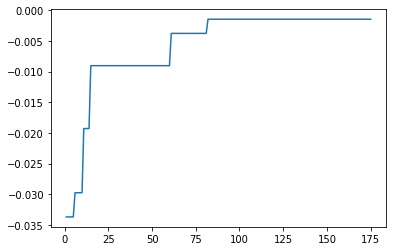

In [35]:
import numpy as np
import matplotlib.pyplot as plt

x = df_plot['iter']
y = df_plot['loss_estimate']

plt.plot(x, best_value)
#plt.legend(title='Parameter where:')
plt.show()

In [40]:
df.query('loss_estimate<0.01')

,x1,x2,x3,x4,loss_estimate,iter
0,585.419433,658.597446,885.307905,685.827810,0.009014,14
0,967.196193,568.916360,876.502353,947.306546,0.003745,60
0,540.251196,943.924867,825.218814,489.288404,0.001436,81
0,945.027097,615.874922,873.756541,891.906239,0.004631,158
